# FCAL Simulation $\alpha$ fitting with LSTM Model

This is mostly a copy of the TimeSeriesFCALgain.ipynb notebook except it uses the mean of all "A" values at each time step as an estimate of the $\alpha$ value which is included as an extra input. In other words, the model takes 51 inputs instead of 50 with the 51st just being the average of the other 50. 

Note that the estimated $\alpha$ is used as both an input feature to the LSTM model (calculated for each time step), but the value at the current time step is added to the LSTM output. This forces the actual LSTM layers to predict the _residual_ of $\alpha$ which gives a more accurate solution.

<hr>

This notebook uses the FCAL simulation data Mike produced with a uniform sawtooth $\alpha$.

This fits an LSTM model using the 50 "A" values as inputs with a 200 time step history to predict the value of $\alpha$ of the current time step.

This is based on the keras Timeseries example for weather forecasting found here: 
https://keras.io/examples/timeseries/timeseries_weather_forecasting


This first cell just reads the data, renames the "b*" columns to "A*", and calculates the true $\alpha$, adding it to the dataframe.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

filename = '/work/epsci/davidl/2023.08.18.AIEC_LSTM_simulation/fcal2.csv'

df = pd.read_csv(filename)

# Rename columns from "bX" to "AX" to better align with what we say vocally
name_map = {}
for i in range(1,51):
    name_map['b'+str(i)] = 'A'+str(i)
df = df.rename(columns=name_map)

# Calculate alpha (should work for any pair)
df['alpha'] = df['A17']/df['g17']


df['Aalpha_est'] = df.filter(like="A").mean(axis=1)

2023-08-26 09:20:09.749473: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 09:20:09.810340: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 09:20:09.811392: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 09:20:11.000018: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Prepare training and validation sets

This will split the data into training and validation sets. Note that the normalization function (copied from the original keras example) is not used since it seemed to result in much worse model fits. This is not such an issue for this data set since the values are already in a small range around 1.

In [2]:
split_fraction = 0.70
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 200   # number of timesteps in the past to use for predicting value(s) for current timestep
future = 0   # number of timesteps in the future to predict value for
learning_rate = 0.002
batch_size = 64
epochs_model1 = 5000
epochs_model2 = 200

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


# Create nomalized training and validation sets
# df_norm  = normalize(df, train_split)  # This gives really bad model fits! Do not use!
df_norm  = df
df_train = df_norm[:train_split-1]
df_valid = df_norm[train_split:]
df_train_labels = df[:train_split-1]  # unormalized!
df_valid_labels = df[train_split:]    # unormalized!

# Chop off ends so we have a full set of past elements and corresponding future
x_train = df_train.filter(like="A").values
y_train = df_train_labels.filter(items=["alpha"])[past+future-1:].values
x_valid = df_valid.filter(like="A").values
y_valid = df_valid_labels.filter(items=["alpha"])[past+future-1:].values
print("x_train shape: "+str(x_train.shape) + "   y_train shape: "+str(y_train.shape))
print("x_valid shape: "+str(x_valid.shape) + "   y_valid shape: "+str(y_valid.shape))


x_train shape: (2099, 51)   y_train shape: (1900, 1)
x_valid shape: (900, 51)   y_valid shape: (701, 1)


### Create Timeseries datasets

This creates datasets in a form that can be easily used for training. Note that we use overlapping points. E.g. time steps 0-199 are used to predict $\alpha_{199}$, time steps 1-200 are used to predict $\alpha_{200}$, etc...

The labels ("y"s defined in the cell above) start with the first predicted value. E.g. y_train[0] = $\alpha_{199}$, y_train[1] = $\alpha_{200}$, ...

In [3]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in  dataset_train.take(1): train_inputs, train_targets = batch
print("  Training: Input shape:", train_inputs.numpy().shape, " Target shape:" , train_targets.numpy().shape)

dataset_valid = keras.preprocessing.timeseries_dataset_from_array(
    x_valid,
    y_valid,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in  dataset_valid.take(1): valid_inputs, valid_targets = batch
print("Validation: Input shape:", valid_inputs.numpy().shape, " Target shape:" , valid_targets.numpy().shape)



  Training: Input shape: (64, 200, 51)  Target shape: (64, 1)
Validation: Input shape: (64, 200, 51)  Target shape: (64, 1)


2023-08-26 09:20:12.779451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int32 and shape [1900]
	 [[{{node Placeholder/_8}}]]
2023-08-26 09:20:12.779976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2023-08-26 09:20:12.901897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [900,51]
	 [[{{node Pl

## Create Model 1

This creates a simple model that uses just the estimated $\alpha$ and one Dense layer with 2 trainable parameters. It is fast and gives a pretty good result (<1% error). The layers and weights of this will be locked, but then used to create a second model later. 

In [4]:
inputs = keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2]))

# Estimated alpha for current time step
alpha_est_out = keras.layers.Lambda(lambda x: x[:, -1, -1])(inputs)
alpha_est_out = keras.layers.Reshape((1,))(alpha_est_out)

# # Scale factor for alpha_est
# lstm_out1 = keras.layers.LSTM(128)(inputs)
# scale_factor_out = keras.layers.Dense(1,activation="sigmoid")(lstm_out1)
# scale_factor_out = keras.layers.Lambda(lambda x: x * 2)(scale_factor_out) # account for sigmoid<1 and we want scale factor that may be >1

# # Residual for corrected alpha
# lstm_out2 = keras.layers.LSTM(64)(inputs)
# residual_out = keras.layers.Dense(1)(lstm_out2)

# # Combine for   model_pred = alpha_est*scale_factor + residual
# prod_out = keras.layers.Multiply()([alpha_est_out, scale_factor_out])
# outputs = keras.layers.Add()([prod_out, residual_out])

outputs = keras.layers.Dense(1, activation="linear")(alpha_est_out)


model1 = keras.Model(inputs=inputs, outputs=outputs, name="model1")
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model1.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 51)]         0         
                                                                 
 lambda (Lambda)             (None,)                   0         
                                                                 
 reshape (Reshape)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## Fit Model 1

Use early stopping and save the best model to a _.h5_ file.

In [5]:
path_checkpoint = "model1_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True,
)

history1 = model1.fit(
    dataset_train,
    epochs=epochs_model1,
    validation_data=dataset_valid,
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/5000


2023-08-26 09:20:13.085259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [1900]
	 [[{{node Placeholder/_28}}]]
2023-08-26 09:20:13.085819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2099,51]
	 [[{{node Placeholder/_0}}]]


23/30 [======================>.......] - ETA: 0s - loss: 2.4243

2023-08-26 09:20:13.571167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [900,51]
	 [[{{node Placeholder/_0}}]]
2023-08-26 09:20:13.571749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [701,1]
	 [[{{node Placeholder/_20}}]]


30/30 [==============================] - 1s 10ms/step - loss: 2.3871 - val_loss: 2.2014
Epoch 2/5000
30/30 [==============================] - 0s 6ms/step - loss: 2.0390 - val_loss: 1.8730
Epoch 3/5000
30/30 [==============================] - 0s 6ms/step - loss: 1.7294 - val_loss: 1.5829
Epoch 4/5000
30/30 [==============================] - 0s 7ms/step - loss: 1.4568 - val_loss: 1.3286
Epoch 5/5000
30/30 [==============================] - 0s 6ms/step - loss: 1.2187 - val_loss: 1.1071
Epoch 6/5000
30/30 [==============================] - 0s 6ms/step - loss: 1.0120 - val_loss: 0.9157
Epoch 7/5000
30/30 [==============================] - 0s 6ms/step - loss: 0.8340 - val_loss: 0.7514
Epoch 8/5000
30/30 [==============================] - 0s 6ms/step - loss: 0.6818 - val_loss: 0.6116
Epoch 9/5000
30/30 [==============================] - 0s 7ms/step - loss: 0.5528 - val_loss: 0.4937
Epoch 10/5000
30/30 [==============================] - 0s 6ms/step - loss: 0.4443 - val_loss: 0.3950
Epoch 11/50

### Loss Function Model 1

n.b. This is plotted on a log scale

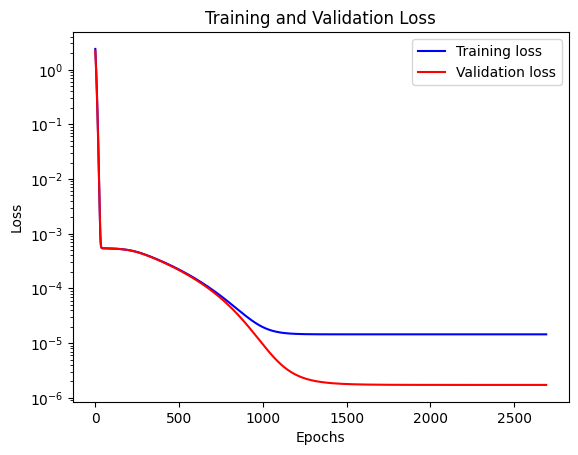

In [6]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()


visualize_loss(history1, "Training and Validation Loss")

## Results Model 1

The following cell performs inference on the entire dataset (training and validation). The results are stored in the original dataframe as column "alpha_model1".

In [7]:
# Create overlapping windows of data
x_all = df_norm.filter(like="A").values
num_windows = x_all.shape[0] - past +1
windows = np.lib.stride_tricks.sliding_window_view(x_all, (past, x_all.shape[1]))

df['alpha_model1'] = np.nan

# Predict using batches and update df
batch_size_ = 32
for i in range(0, num_windows, batch_size_):
    batch_windows = windows[i:i+batch_size_]
     # Reshape batch_windows to match the model's input shape
    batch_windows_reshaped = np.reshape(batch_windows, (batch_windows.shape[0], past, batch_windows.shape[-1]))
    y_pred_batch = model1.predict(batch_windows_reshaped, verbose=0)
    y_pred_batch_flattened = y_pred_batch.flatten()
    this_batch_size = batch_windows.shape[0]
    df.loc[i+past-1:i+this_batch_size+past-1-1, 'alpha_model1'] = y_pred_batch
    print("\rprocessed: {}/{}".format(i, num_windows), end="")

print("\rprocessed: {}/{}".format(num_windows, num_windows), end="")

processed: 2801/2801

# $\alpha$ Model 1 vs Truth

The top plot below shows the true $\alpha$ and the one predicted by model 1. Since the model requires 200 past timesteps, its predictions are only available for timestep 200 and later.

The bottom plot shows the error (residual) bewtween $\alpha$ and the model 1 prediction.

<Axes: >

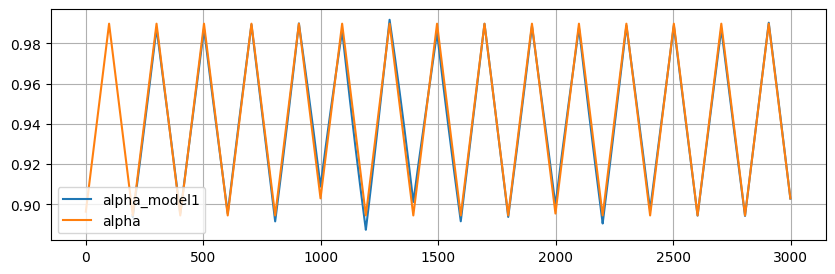

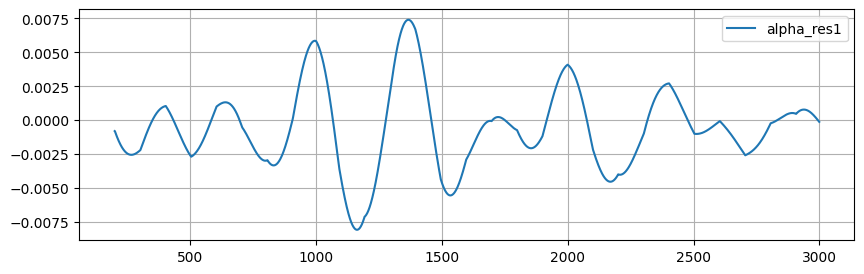

In [8]:
df.plot(y=["alpha_model1", "alpha"], kind="line", grid=True, figsize=(10,3))

df["alpha_res1"] = df["alpha_model1"] - df["alpha"]
df.plot(y=["alpha_res1"], kind="line", grid=True, figsize=(10,3))

## Create Model 2

This creates an LSTM model that uses just the model 1 output of a corrected estimated $\alpha$ as input. The LSTM model is then trained to correct the residual. The layers of model 1 are reused here, but the two trainable parameters are locked so as not no be updated by this model's training, forcing the additional layers of this model to fit to the residual.

In [9]:
# inputs = keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2]))

# # Estimated alpha for current time step
# alpha_est_out = keras.layers.Lambda(lambda x: x[:, -1, -1])(inputs)
# alpha_est_out = keras.layers.Reshape((1,))(alpha_est_out)

# # Scale factor for alpha_est
# lstm_out1 = keras.layers.LSTM(128)(inputs)
# scale_factor_out = keras.layers.Dense(1,activation="sigmoid")(lstm_out1)
# scale_factor_out = keras.layers.Lambda(lambda x: x * 2)(scale_factor_out) # account for sigmoid<1 and we want scale factor that may be >1

# Lock the parameters in model 1
outputs.trainable = False

# Residual for corrected alpha
lstm_out = keras.layers.LSTM(200)(inputs)
residual_out = keras.layers.Dense(1, activation="tanh")(lstm_out)

# Add model 1 and residual to make outputs for model 2
outputs2 = keras.layers.Add()([outputs, residual_out])

# outputs = keras.layers.Dense(1, activation="linear")(alpha_est_out)


model2 = keras.Model(inputs=inputs, outputs=outputs2, name="model2")
model2.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model2.summary()

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 51)]    0           []                               
                                                                                                  
 lambda (Lambda)                (None,)              0           ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1)            0           ['lambda[0][0]']                 
                                                                                                  
 lstm (LSTM)                    (None, 200)          201600      ['input_1[0][0]']                
                                                                                             

2023-08-26 09:30:07.429035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 09:30:07.430405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 09:30:07.431857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Fit Model 2

Use early stopping and save the best model to a _.h5_ file.

In [10]:
path_checkpoint = "model2_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=50)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history2 = model2.fit(
    dataset_train,
    epochs=epochs_model1,
    validation_data=dataset_valid,
    callbacks=[es_callback, modelckpt_callback],
)


Epoch 1/5000


2023-08-26 09:30:07.726315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 09:30:07.728067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 09:30:07.729229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

30/30 [==============================] - ETA: 0s - loss: 0.8790

2023-08-26 09:30:18.991973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 09:30:18.993829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 09:30:18.994932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.79789, saving model to model2_checkpoint.h5
30/30 [==============================] - 13s 375ms/step - loss: 0.8790 - val_loss: 0.7979
Epoch 2/5000
30/30 [==============================] - ETA: 0s - loss: 0.7044
Epoch 2: val_loss improved from 0.79789 to 0.60749, saving model to model2_checkpoint.h5
30/30 [==============================] - 10s 334ms/step - loss: 0.7044 - val_loss: 0.6075
Epoch 3/5000
30/30 [==============================] - ETA: 0s - loss: 0.3939
Epoch 3: val_loss improved from 0.60749 to 0.00099, saving model to model2_checkpoint.h5
30/30 [==============================] - 10s 340ms/step - loss: 0.3939 - val_loss: 9.9465e-04
Epoch 4/5000
30/30 [==============================] - ETA: 0s - loss: 0.0090
Epoch 4: val_loss improved from 0.00099 to 0.00008, saving model to model2_checkpoint.h5
30/30 [==============================] - 10s 350ms/step - loss: 0.0090 - val_loss: 8.1819e-05
Epoch 5/5000
30/30 [============================

### Loss Function Model 2

n.b. This is plotted on a log scale

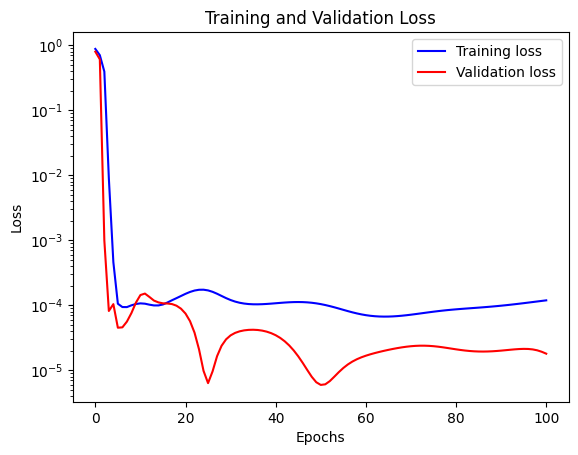

In [11]:
visualize_loss(history2, "Training and Validation Loss")

## Results Model 2

The following cell performs inference on the entire dataset (training and validation). The results are stored in the original dataframe as column "alpha_model2".

In [12]:
df['alpha_model2'] = np.nan

# Predict using batches and update df
batch_size_ = 32
for i in range(0, num_windows, batch_size_):
    batch_windows = windows[i:i+batch_size_]
     # Reshape batch_windows to match the model's input shape
    batch_windows_reshaped = np.reshape(batch_windows, (batch_windows.shape[0], past, batch_windows.shape[-1]))
    y_pred_batch = model2.predict(batch_windows_reshaped, verbose=0)
    y_pred_batch_flattened = y_pred_batch.flatten()
    this_batch_size = batch_windows.shape[0]
    df.loc[i+past-1:i+this_batch_size+past-1-1, 'alpha_model2'] = y_pred_batch
    print("\rprocessed: {}/{}".format(i, num_windows), end="")

print("\rprocessed: {}/{}".format(num_windows, num_windows), end="")

2023-08-26 09:47:51.015122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 09:47:51.017176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 09:47:51.018479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

processed: 2801/2801

2023-08-26 09:48:02.162815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-26 09:48:02.164137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-26 09:48:02.165535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# $\alpha$ Model 2 vs Truth

The top plot below shows the true $\alpha$ and the one predicted by model 2. Since the model requires 200 past timesteps, its predictions are only available for timestep 200 and later.

The bottom plot shows the error (residual) bewtween $\alpha$ and the model 2 prediction.

<Axes: >

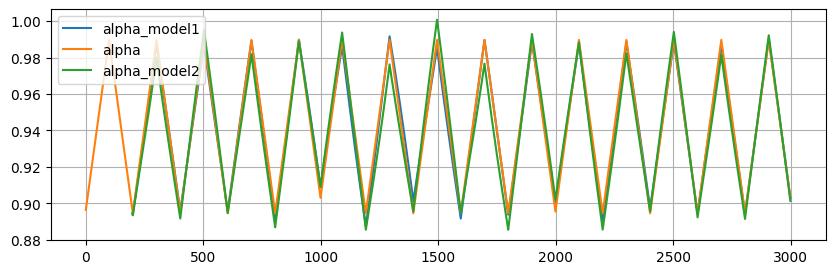

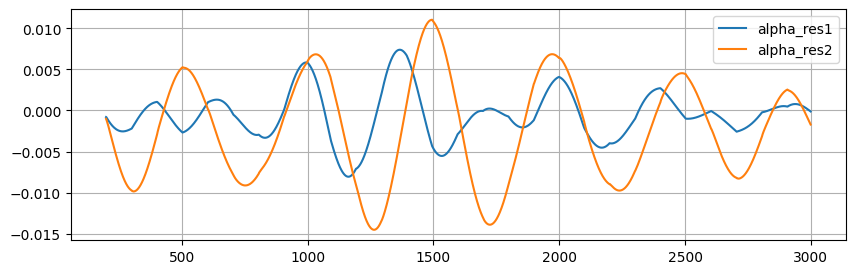

In [13]:
df.plot(y=["alpha_model1", "alpha", "alpha_model2"], kind="line", grid=True, figsize=(10,3))

df["alpha_res2"] = df["alpha_model2"] - df["alpha"]
df.plot(y=["alpha_res1", "alpha_res2"], kind="line", grid=True, figsize=(10,3))

# Basement
<hr>

### Example predictions

Plot a few examples showing the $\alpha$ truth history and the model prediction. This is also carried over from the keras weather example. The red "X" is just the last point in the truth history since here, we are not trying to predict the future, only use the past to predict the present.

n.b. Unlike the original example for the weather which included Temperature in the features and was used to predict Temperature in the future, this problem does not directly measure $\alpha$. Thus these blue points are useful to guide the human eye, but are not values the model sees.

The first 3 plots are from the validation set while the second three are from the training set.

1/1 [==============================] - 0s 43ms/step


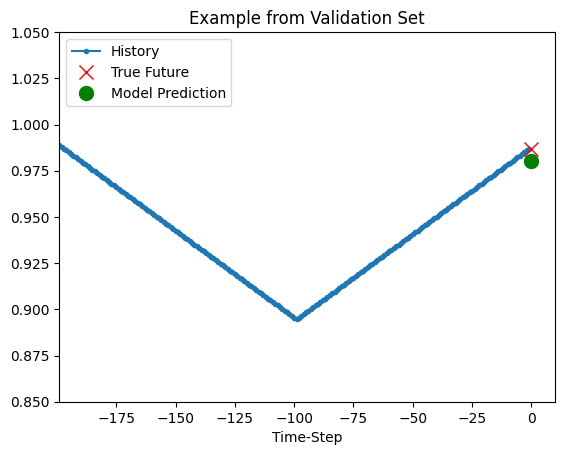

1/1 [==============================] - 0s 44ms/step


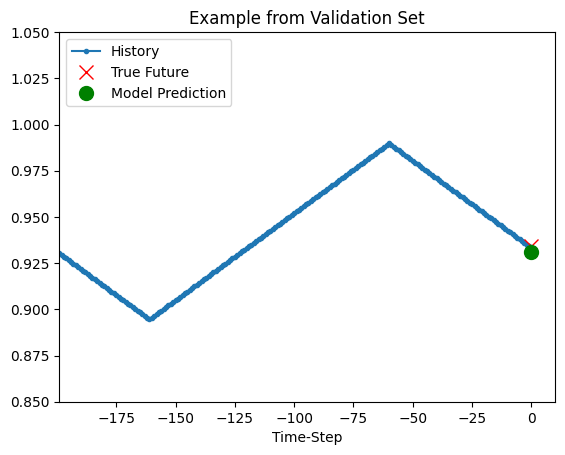

1/1 [==============================] - 0s 44ms/step


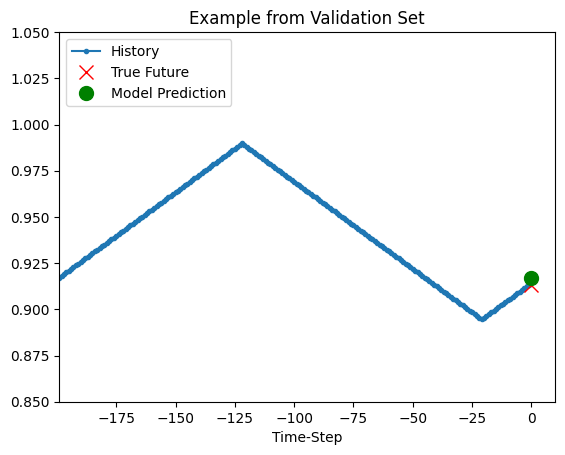

1/1 [==============================] - 0s 44ms/step


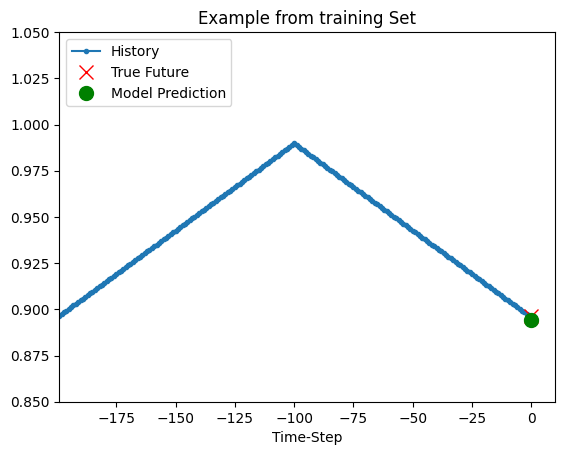

1/1 [==============================] - 0s 45ms/step


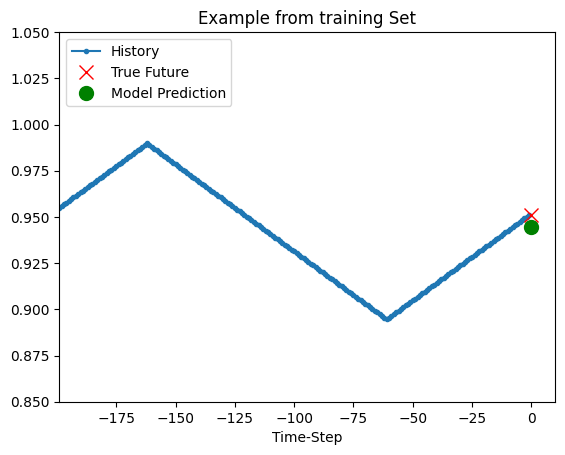

1/1 [==============================] - 0s 42ms/step


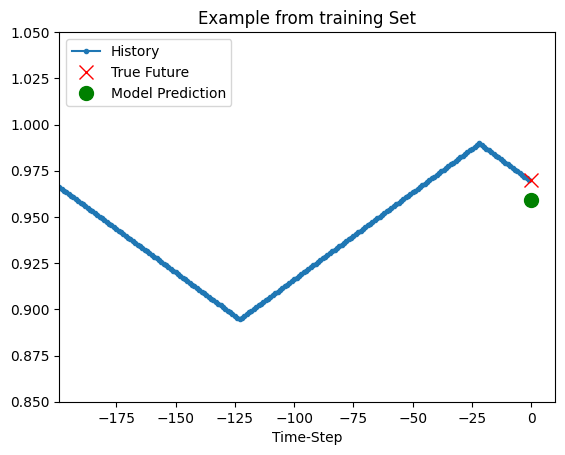

In [14]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future_ = delta
    else:
        future_ = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future_, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend(loc="upper left")
    plt.xlim([time_steps[0], (future_ + 5) * 2])
    plt.ylim([0.85, 1.050])
    plt.xlabel("Time-Step")
    plt.show()
    return

# This has the alpha history with last point being the same as the label
alpha_valid = df_valid_labels.filter(items=["alpha"])[:-(past+future)].values
alpha_train = df_train_labels.filter(items=["alpha"])[:-(past+future)].values

 
# Validation examples
for i in range(3):
    start = i*62
    x = np.expand_dims(x_valid[start:start+past], 0)
    y_history = alpha_valid[start:start+past-1]
    y_true = y_history[-1]
    # print("shape x: ", x.shape, '  y_history:',y_history.shape, ' y_true:',y_true.shape)
    y_pred = model2.predict(x)
    # print('shape y_pred:',y_pred.shape)
    show_plot(  [y_history, y_true, y_pred], 0, "Example from Validation Set")

# Training examples
for i in range(3):
    start = i*62
    x = np.expand_dims(x_train[start:start+past], 0)
    y_history = alpha_train[start:start+past-1]
    y_true = y_history[-1]
    # print("shape x: ", x.shape, '  y_history:',y_history.shape, ' y_true:',y_true.shape)
    y_pred = model2.predict(x)
    # print('shape y_pred:',y_pred.shape)
    show_plot(  [y_history, y_true, y_pred], 0, "Example from training Set")
